In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    silhouette_score,
    adjusted_rand_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset
df = pd.read_csv("extracted_features.csv")
X = df.drop(columns=["label"]).values
y_true_str = df["label"].values

# Load label encoder and scaler
le = joblib.load("label_encoder.pkl")
scaler = joblib.load("scaler.pkl")

# Encode true labels
y_true = le.transform(y_true_str)

# Split (same 80/20 stratified split as in training)
from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(
    X, y_true, test_size=0.2, stratify=y_true, random_state=42
)
X_test_scaled = scaler.transform(X_test)

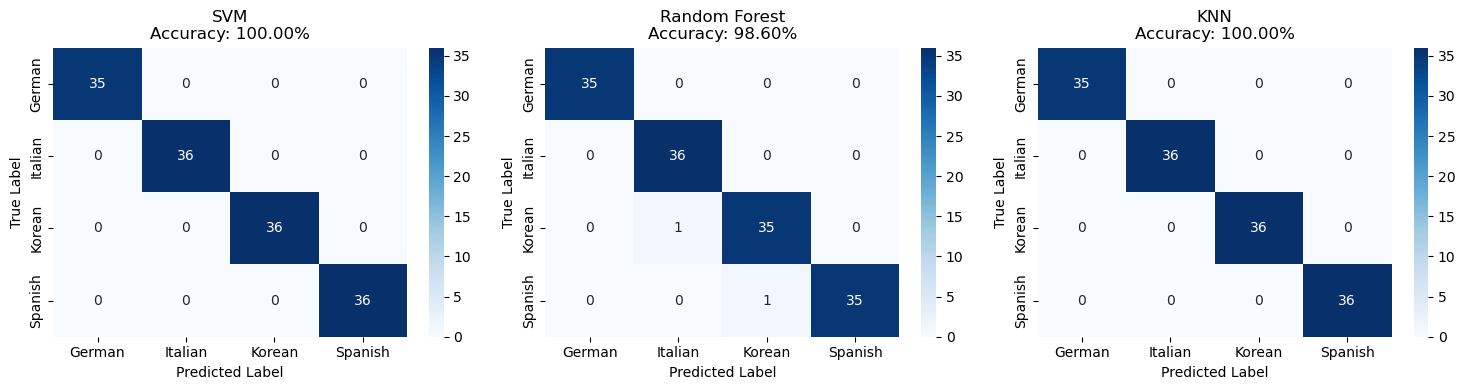


📊 Classification Performance:


,Accuracy,Precision,Recall,F1
SVM,1.000,1.0000,1.000,1.000
Random Forest,0.986,0.9862,0.986,0.986
KNN,1.000,1.0000,1.000,1.000


In [3]:
# Model names and files
model_names = ["SVM", "Random Forest", "KNN"]
results = {}

plt.figure(figsize=(15, 4))
for i, name in enumerate(model_names, 1):
    # Load model
    model = joblib.load(f"{name.replace(' ', '_')}_model.pkl")
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Metrics (weighted average for multiclass)
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    results[name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}
    
    # Confusion Matrix
    plt.subplot(1, 3, i)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm, annot=True, fmt="d", 
        xticklabels=le.classes_, yticklabels=le.classes_,
        cmap="Blues"
    )
    plt.title(f"{name}\nAccuracy: {acc:.2%}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

plt.tight_layout()
plt.show()

# Display metrics table
print("\n📊 Classification Performance:")
display(pd.DataFrame(results).T.round(4))

🔍 Clustering Evaluation:
- Purity:             0.5969
- Adjusted Rand Index: 0.3107
- Silhouette Score:   0.2431


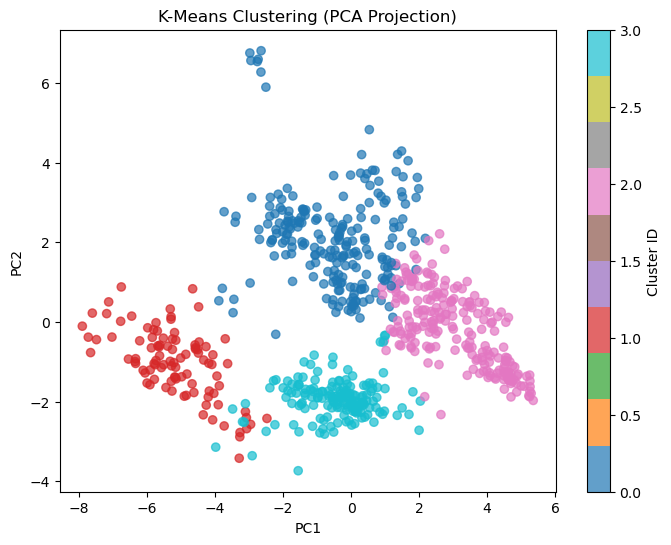


🧮 Cluster Composition by Language:


Language,German,Italian,Korean,Spanish
Cluster,,,,
0,53,90,1,79
1,0,0,0,97
2,73,1,149,1
3,46,89,30,3


In [4]:
# Use full dataset (unsupervised → no train/test split needed)
X_full = df.drop(columns=["label"]).values
X_full_scaled = scaler.transform(X_full)

# Re-run K-Means with k=4 (as per number of languages)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_full_scaled)

# True labels for external evaluation
true_labels = le.transform(df["label"])

# --- Purity ---
def cluster_purity(cluster_labels, true_labels):
    total = len(true_labels)
    purity = 0
    for cluster_id in np.unique(cluster_labels):
        mask = cluster_labels == cluster_id
        cluster_true = true_labels[mask]
        if len(cluster_true) == 0:
            continue
        most_common = np.bincount(cluster_true).max()
        purity += most_common
    return purity / total

purity = cluster_purity(cluster_labels, true_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)
sil = silhouette_score(X_full_scaled, cluster_labels)

print("🔍 Clustering Evaluation:")
print(f"- Purity:             {purity:.4f}")
print(f"- Adjusted Rand Index: {ari:.4f}")
print(f"- Silhouette Score:   {sil:.4f}")

# --- Visualize clusters (PCA) ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_full_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.title("K-Means Clustering (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Optional: Show cluster composition by language
df_eval = pd.DataFrame({
    "Language": df["label"],
    "Cluster": cluster_labels
})
print("\n🧮 Cluster Composition by Language:")
display(df_eval.groupby(["Cluster", "Language"]).size().unstack(fill_value=0))